In [1]:
# database_path load from config file
from config import settings
from pathlib import Path
settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/(settings_simu.lower()+'_vas')).with_suffix('.db')
database_psd = (root /settings_simu/(settings_simu.lower())).with_suffix('.db')

In [2]:
#load the metadata as we usually do
import sqlite3
import numpy as np
conn = sqlite3.connect(database_psd)
c = conn.cursor()
c.execute("SELECT freq FROM metadata")
freq = c.fetchone()[0]
freq = np.frombuffer(freq, dtype=np.float64)


In [3]:
import sqlite3
import numpy as np

conn = sqlite3.connect(database_path)
c = conn.cursor()
c.execute("""SELECT * FROM VAS_notch WHERE system_name = 'system_1' AND amplitude_notch =0.15
          LIMIT 400""")

data = c.fetchall()
c.execute("""SELECT * FROM ORIGINAL_PSD
          WHERE system_name = 'system_1'""")
data_psd = c.fetchall()

# initialize lists to store the column data
sys_name_list = []
f_aff_list = []
amp_list = []
psd_list = []

# populate the lists with data
for row in data:
    sys_name_list.append(row[2])
    f_aff_list.append(row[3])
    amp_list.append(row[4])
    psd_list.append(np.frombuffer(row[5], dtype=np.float64))

# convert lists to numpy arrays
sys_name_array = np.array(sys_name_list)
f_aff_array = np.array(f_aff_list)
amp_array = np.array(amp_list)
psd_array = np.array(psd_list)


In [4]:
psd_array

array([[7.98596218e-06, 1.69440594e-05, 7.01845365e-05, ...,
        1.52366729e-16, 1.52193446e-16, 7.60678515e-17],
       [7.98596218e-06, 9.96361881e-06, 1.35361626e-05, ...,
        1.52366729e-16, 1.52193446e-16, 7.60678515e-17],
       [7.98596218e-06, 9.96361881e-06, 1.02783049e-05, ...,
        1.52366729e-16, 1.52193446e-16, 7.60678515e-17],
       ...,
       [9.73084956e-06, 1.57816011e-05, 1.58180743e-05, ...,
        1.24009984e-16, 1.23788102e-16, 6.18570880e-17],
       [9.73084956e-06, 1.57816011e-05, 1.58180743e-05, ...,
        1.24009984e-16, 1.23788102e-16, 6.18570880e-17],
       [9.73084956e-06, 1.57816011e-05, 1.58180743e-05, ...,
        1.24009984e-16, 1.23788102e-16, 6.18570880e-17]])

In [5]:
psd_orig = np.array([np.frombuffer(row[3], dtype=np.float64) for row in data_psd])


Text(0.5, 0, 'Frequency [Hz]')

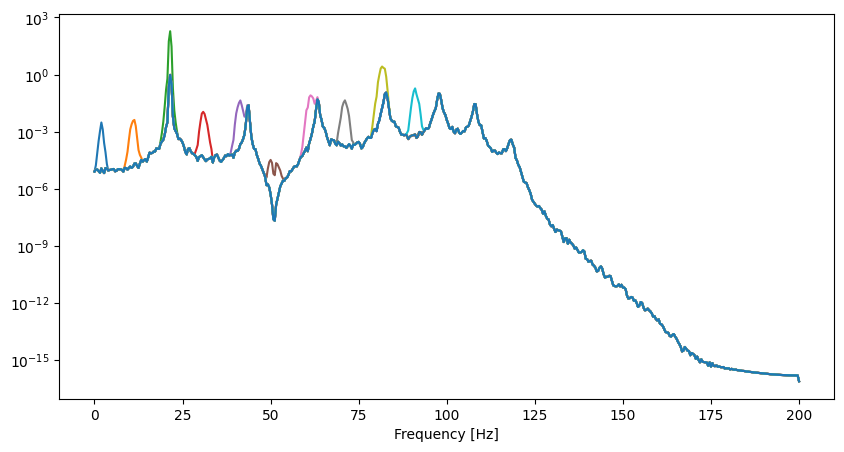

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
for i in range(0,50,5):
    ax.plot(freq,psd_array[i,:],label='freq = '+str(f_aff_list[i]))
ax.plot(freq,psd_orig[0],label='original')

ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')


# Dataloader

In [7]:
from psm.models.prepare_data import CreateTransformer, PSDNotchDataset

cr = CreateTransformer(database_path=database_psd,freq=freq,freq_min=0,freq_max=150)
transform_psd=cr.transform_psd
transform_label=cr.transform_label

dataset = PSDNotchDataset(database_path=database_path, system_name='system_1', transform=transform_psd, transform_label=transform_label, preload=True)

for i in dataset:
    print(i[0].shape)
    break


torch.Size([385])


In [8]:
healthy = dataset.get_original()
new_freq = cr.new_freq

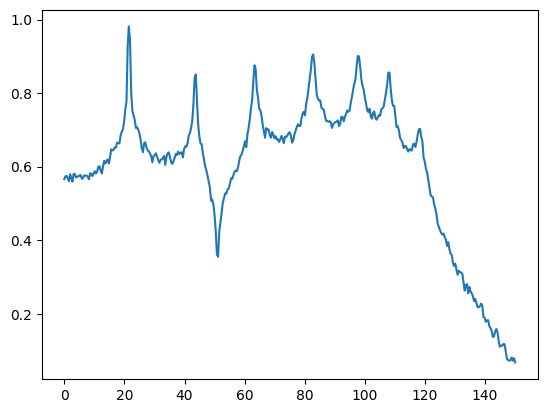

In [9]:
plt.plot(new_freq,healthy[0][0],label='original')
